In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from collections import defaultdict
import copy
import os
import pprint
import itertools

import hydra
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white', font_scale=1.3, palette=sns.color_palette('Set2'),)
import sqlalchemy as sa
import marimo as mo
import seaborn as sns
import lightning.pytorch
import polars as pl
from tqdm import tqdm

from conf import conf
from dafm import datasets, models, plots, utils

In [3]:
with hydra.initialize(version_base=utils.HYDRA_INIT['version_base'], config_path='../conf'):
    cfg = hydra.compose(utils.HYDRA_INIT['config_name'], overrides=[
        'model=ScoreMatchingMarginalBao2024EnSF',
        'dataset=NavierStokesDim256',
        'dataset.use_predicted_state_perturbation=true',
        'dataset.predicted_state_perturbation_std=1e-2',
        'dataset.time_step_size=1e-4',
        'dataset.time_step_count=4000',
    ])
    engine = conf.get_engine()
    conf.orm.create_all(engine)
    with conf.sa.orm.Session(engine) as db:
        cfg = conf.orm.instantiate_and_insert_config(db, OmegaConf.to_container(cfg, resolve=True))
        pprint.pp(cfg.dataset)

NavierStokes(trajectory_stored_on_gpu_max_state_dimension=200000,
             save_data_every_n_time_steps=None,
             state_dimension=196608,
             model_noise_std=0.0,
             observation_noise_std=0.1,
             predicted_state_initial_condition_add_true_state=True,
             predicted_state_initial_condition_std=1.0,
             predicted_state_model_noise_std=0.0,
             predicted_state_count=20,
             time_step_count=4000,
             time_step_count_drop_first=0,
             time_step_size=0.0001,
             observe_every_n_time_steps=100,
             observe=ATan(id=1),
             integrator=<Integrator.RUNGE_KUTTA_4: 1>,
             state_perturbation=<StatePerturbation.IDENTITY: 1>,
             use_predicted_state_perturbation=True,
             predicted_state_perturbation_std=0.01,
             id=84,
             grid_horizontal_count=256,
             grid_vertical_count=256,
             grid_width=2.0,
             grid_h

In [4]:
dynamics = datasets.get_dynamics_dataset(cfg.dataset, np.random.default_rng(utils.RNG_RANDBITS[cfg.rng_seed]), 'cpu')

In [6]:
not any (d.isnan().any() for d in itertools.chain([dynamics.true_state], (dynamics.true_state for _ in dynamics)))

True

In [14]:
data_list = [dynamics.true_state, *(dynamics.true_state for _ in dynamics)]
len(data_list)

4001

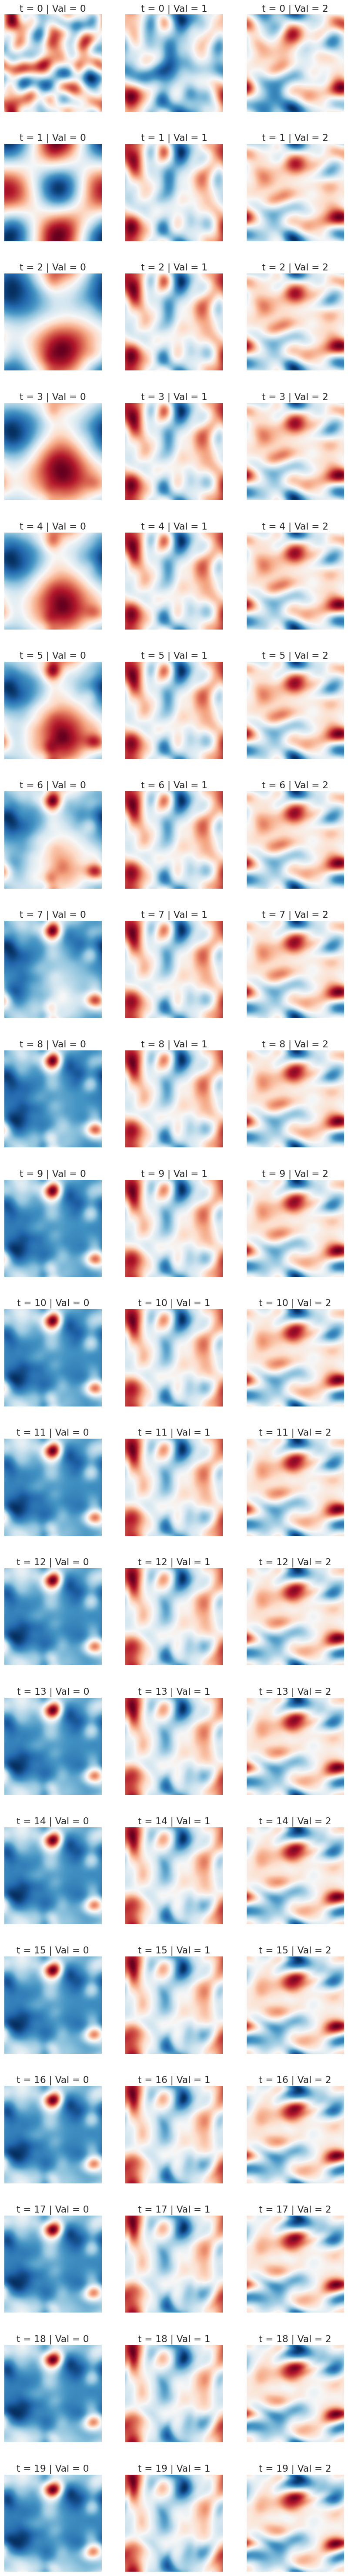

In [11]:
data = rearrange(
    data_list,
    'time_step_count 1 (value_count grid_horizontal_count grid_vertical_count) -> time_step_count value_count grid_horizontal_count grid_vertical_count',
    value_count=3, grid_vertical_count=cfg.dataset.grid_vertical_count, grid_horizontal_count=cfg.dataset.grid_horizontal_count,
)[1::100]
g = sns.FacetGrid(
    data=pd.DataFrame({i: range(data.shape[0]) for i in range(data.shape[1])}).melt(var_name='Value', value_name='Time step'),
    # height=5,
    row='Time step',
    col='Value',
).set_titles('t = {row_name} | Val = {col_name}')
for (row, col, hue), _ in g.facet_data():
    ax = g.axes[row][col]
    ax.set_axis_off()
    im_out = ax.imshow(data[row, col], cmap='RdBu')
# g.figure.subplots_adjust(right=.8)
# cbar_ax = g.figure.add_axes([0.85, 0.17, 0.05, 0.7])
# g.figure.colorbar(im_out, cax=cbar_ax)
# fig, axs = plt.subplots(data.shape[0], 3, figsize=(18, 58))
# for ax_row, data_row in zip(axs, data):
#     for ax, x in zip(ax_row, data_row):
#         ax.imshow(x, cmap='RdBu')